In [ ]:
!pip install pandas
!pip install scikeras[tensorflow]

In [ ]:
!chmod +x /kaggle/input/classification2/download_cl2.sh
!source /kaggle/input/classification2/download_cl2.sh

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as  plt
import gc
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
def alter_data(X):
    X = X.values
    turn = X[:,64]
    black_to_play = np.where(turn == -1)[0]
    # Multiply the values from indexes 0 to 63 by -1 where index 64 is 0
    X[black_to_play, :64] *= -1
    X = X[:, 0:64].reshape((X.shape[0], 8 , 8))
    return X

In [ ]:
def load_n_datasets(n,foldername):
    all_datasets = []
    filenames = os.listdir(foldername)
    for i in range(n):
        filename = filenames[i]
        if filename.endswith('.csv'):
            dataset = pd.read_csv(os.path.join(foldername, filename))
            all_datasets.append(dataset)
    combined_dataset = pd.concat(all_datasets, ignore_index=True)
    
    X =  combined_dataset.iloc[:,0:-1]
    y =  combined_dataset["Evaluation"].astype(int)
    combined_dataset = None
    dataset = None
    all_datasets = None
    return X,y

In [ ]:
def bit_map(X):
    channels = np.zeros((X.shape[0],8, 8, 12))  # 12 channels for 6 types of pieces for each player
    # Generate separate channels for each player
    for player in range(2):  # 0 for white pieces, 1 for black pieces
        if player ==0:
            for piece_type in range(6):  # 6 types of pieces
                piece_mask = X == (piece_type + 1)
                channels[:, :, :, player * 6 + piece_type] = piece_mask.astype(np.float32)
        else:
            for piece_type in range(6):  # 6 types of pieces
                piece_mask = -1*(X == (-piece_type - 1))
                channels[:, :, :, player * 6 + piece_type] = piece_mask.astype(np.float32)
    X = None
    return channels

In [ ]:
n_datasets = 2
X_chess_data,y_chess_data = load_n_datasets(n_datasets,'classification_data2')

#X_chess_data, _, y_chess_data, _ = train_test_split(X_chess_data, y_chess_data, test_size=0.01, random_state=42, stratify=y_chess_data)

print(type(X_chess_data))
print(X_chess_data.shape)

X = alter_data(X_chess_data)
X = bit_map(X)
y = to_categorical(y_chess_data)

In [8]:
X_chess_data = None
y_chess_data = None
gc.collect()

0

In [9]:
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val,X_test,y_val,y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)
#80% training, 10% validation and 10% testing.

In [10]:
X = None
y = None
gc.collect()

0

In [11]:
import tensorflow
from keras.models import Sequential 
from keras.layers import Conv2D, Flatten, BatchNormalization, Dense, Dropout
from keras.activations import elu
from keras.optimizers import SGD,Adam

tensorflow.random.set_seed(101)

In [12]:
def create_model_mlp1(input_shape,num_classes):
    mlp_model = Sequential()

    # Add hidden layers with ReLU activation and dropout
    mlp_model.add(Dense(1048, activation='relu', input_shape=input_shape))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(500, activation='relu'))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(50, activation='relu'))
    mlp_model.add(Dropout(0.2))

    # Layer to ensure the output matches the labels in shape
    mlp_model.add(Flatten())
    
    # Add output layer with softmax activation
    mlp_model.add(Dense(num_classes, activation='softmax'))

    # Compile model with Adam optimizer
    adam = Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.99, epsilon=1e-8)
    mlp_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    mlp_model.summary()
    return mlp_model

In [13]:
def create_model_cnn(input_shape,num_classes):
    cnn_model = Sequential()

    # Add convolutional layers with ELU activation and batch normalization
    cnn_model.add(Conv2D(20, (5, 5), activation=elu, input_shape=input_shape, padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.3))
    
    cnn_model.add(Conv2D(50, (3, 3), activation=elu, padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.3))
    
    # Add fully connected layer
    cnn_model.add(Flatten())
    cnn_model.add(Dense(500, activation=elu))
    cnn_model.add(Dropout(0.3))
    
    # Add output layer with softmax activation
    cnn_model.add(Dense(num_classes, activation='softmax'))

    # Compile model with SGD optimizer
    sgd = SGD(learning_rate=0.01, nesterov=False)
    cnn_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    cnn_model.summary()
    return cnn_model

In [14]:
def create_model_mlp2(input_shape,num_classes):
    mlp_model = Sequential()

    # Add hidden layers with ReLU activation and dropout
    mlp_model.add(Dense(2048, activation='elu', input_shape=input_shape))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(2048, activation='elu'))
    mlp_model.add(Dropout(0.2))
    mlp_model.add(Dense(1050, activation='elu'))
    mlp_model.add(Dropout(0.2))

    # Layer to ensure the output matches the labels in shape
    mlp_model.add(Flatten())
    
    # Add output layer with softmax activation
    mlp_model.add(Dense(num_classes, activation='softmax'))

    # Compile model with Adam optimizer
    adam = Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.99, epsilon=1e-8)
    mlp_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    mlp_model.summary()
    return mlp_model

In [15]:
def run_model(X_train,y_train,X_val,y_val,model_params,batch_size,epochs):

    #model = create_model(
    #                     activation=model_params['activation'],
    #                     n_layers=model_params['n_layers'],
    #                     n_neurons=model_params['n_neurons'],
    #                     dropout=model_params['dropout'],
    #                     l2=model_params['l2']
    #                     )
    
    input_shape = X_train.shape[1:]
    num_classes = 15
    print(input_shape)
    #model = create_model_mlp1(input_shape,num_classes)
    model = create_model_cnn(input_shape,num_classes)
    #model = create_model_mlp2(input_shape,num_classes)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    return history,model

In [16]:
model_params = {
    'activation' : 'elu',
    'n_layers' : 3,
    'n_neurons' : 300,
    'dropout' : 0.4,
    'l2' : 0.01
}
batch_size = 128
epochs = 10

history,model = run_model(X_train,y_train,X_val,y_val,model_params,batch_size,epochs)

(8, 8, 12)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 20)       │         6,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 50)       │         9,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 50)       │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     1,600,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,623,365 (6.19 MB)

 Trainable params: 1,623,225 (6.19 MB)

 Non-trainable params: 140 (560.00 B)

Epoch 1/10


I0000 00:00:1713131187.756727     102 service.cc:145] XLA service 0x7fa6340053b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713131187.756779     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   62/12460 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.3777 - loss: 2.7361  

I0000 00:00:1713131193.442851     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12460/12460 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.5566 - loss: 1.7143 - val_accuracy: 0.5773 - val_loss: 1.4897
Epoch 2/10
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5760 - loss: 1.5127 - val_accuracy: 0.5791 - val_loss: 1.4649
Epoch 3/10
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5774 - loss: 1.4881 - val_accuracy: 0.5805 - val_loss: 1.4499
Epoch 4/10
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5789 - loss: 1.4734 - val_accuracy: 0.5821 - val_loss: 1.4343
Epoch 5/10
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5798 - loss: 1.4625 - val_accuracy: 0.5829 - val_loss: 1.4256
Epoch 6/10
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5805 - loss: 1.4537 - val_accuracy: 0.5842 - val_loss: 1.4114
Epoch 7/10
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5814 - loss: 1.4457 - val_accuracy: 0.5850 - val_loss: 1.4016
Epoch 8/10
12460/12460 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.5820 - lo

In [17]:
from sklearn.metrics import accuracy_score

loss,acc = model.evaluate(X_test,y_test)

print("Loss:",loss)
print("Accuracy:",acc)

6230/6230 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5891 - loss: 1.3766
Loss: 1.3840793371200562
Accuracy: 0.5866017937660217


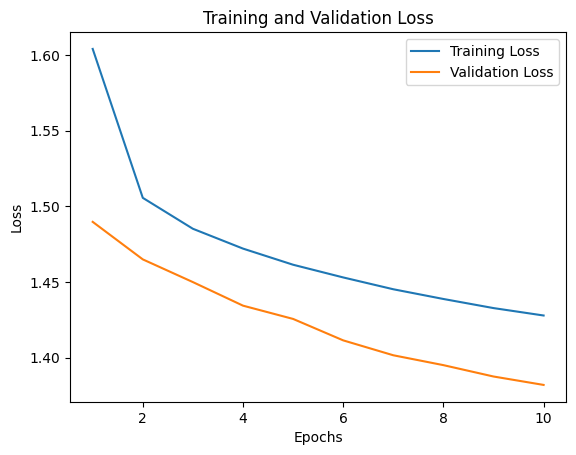

In [18]:
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_cnn_alter_data')
plt.show()

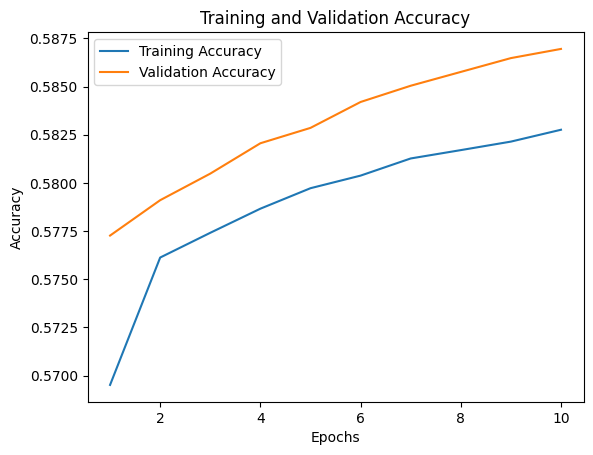

In [19]:
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('acc_cnn_alter_data')
plt.show()

In [31]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

predicted = np.argmax(model.predict(X_test),axis=1)

actual = np.argmax(y_test,axis=1)

6230/6230 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


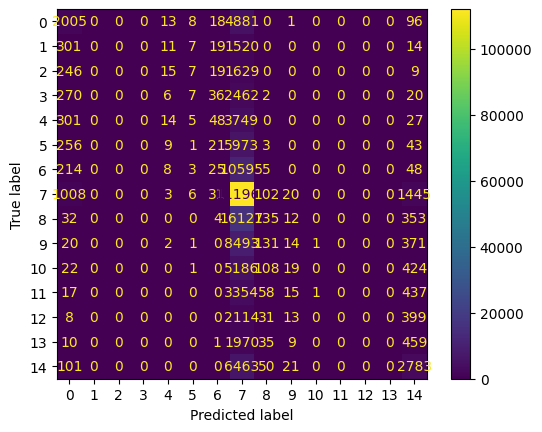

In [32]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [i for i in range(15)])

cm_display.plot()
plt.show() 

In [30]:
y_df = pd.DataFrame(y_test)
class_counts = y_df.value_counts()
class_counts = class_counts.sort_index()

print(class_counts)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14 
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      9418
                                                                 1.0  0.0      2484
                                                            1.0  0.0  0.0      2565
                                                       1.0  0.0  0.0  0.0      3882
                                                  1.0  0.0  0.0  0.0  0.0      5760
                                             1.0  0.0  0.0  0.0  0.0  0.0      9033
                                        1.0  0.0  0.0  0.0  0.0  0.0  0.0     16663
                                   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    114580
                              1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     10898
                         1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      6306
                    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      4144
  